In [24]:
import gc
import itertools
import os
import shutil
from pathlib import Path
import matplotlib.pyplot as plt

import comet_ml
import tensorflow as tf
import torch
import torch.optim as optim
from load_data import load_data
from model import init_model
from rsl_depth_completion.conditional_diffusion.config import cfg as cfg_cls
from rsl_depth_completion.conditional_diffusion.custom_trainer import ImagenTrainer
from rsl_depth_completion.conditional_diffusion.utils import (
    dict2mdtable,
    log_params_to_exp,
)
from rsl_depth_completion.diffusion.utils import set_seed
from rsl_depth_completion.conditional_diffusion.pipeline_utils import (
    get_ds_kwargs, setup_train_pipeline
)

torch.backends.cudnn.benchmark = True



In [25]:

logdir_name = "debug"
# logdir_name = "standalone_trainer"
cfg, train_logdir = setup_train_pipeline(logdir_name)
cfg.disabled = True
cfg.input_res = 256
cfg.unets_output_res = [64, 256]
cfg.only_super_res = True
# cfg.input_img_size=[cfg.input_res,cfg.input_res]
# cfg.unets_output_res[0]=256
cfg.use_triplet_loss=True

ds_kwargs = get_ds_kwargs(cfg)

ds, train_dataloader, val_dataloader = load_data(
    ds_name=cfg.ds_name, do_overfit=cfg.do_overfit, cfg=cfg, **ds_kwargs
)
x=ds[0]
# eval_batch = ds.eval_batch
sample0_idx = 310 + 5
sample1_idx = 80 + 5
eval_batch = torch.utils.data.default_collate([ds[sample0_idx],ds[sample1_idx]])

# eval_batch = {k:v[:cfg.batch_size] for k,v in torch.load("eval_batch_rand_sdm.pt")[cfg.input_res].items()}

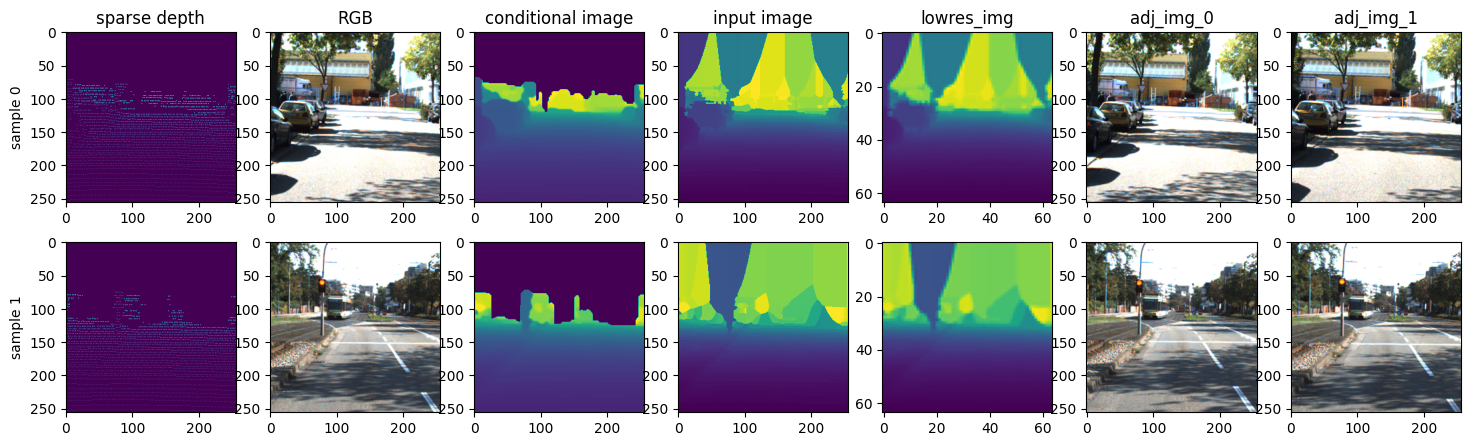

In [26]:
keys = ['sdm', 'rgb', 'cond_img', 'input_img', 'lowres_img']
fig, axs = plt.subplots(cfg.batch_size, len(keys)+len(eval_batch['adj_imgs']), figsize=(18, 5))
key_to_full_name = {
    'sdm': 'sparse depth',
    'rgb': 'RGB',
    'cond_img': 'conditional image',
    'input_img': 'input image',
}
for sample_idx in range(cfg.batch_size):
    for idx, key in enumerate(keys):
        x = eval_batch[key][sample_idx].permute(1,2,0)
        axs[sample_idx, idx].imshow(x/x.max())
        if sample_idx == 0:
            axs[sample_idx, idx].set_title(key_to_full_name.get(key, key))
    adj_imgs = eval_batch['adj_imgs'][sample_idx]
    for idx, img in enumerate(adj_imgs):
        x = img.permute(1,2,0)
        axs[sample_idx, idx+len(keys)].imshow(x/x.max())
        if sample_idx == 0:
            axs[sample_idx, idx+len(keys)].set_title(f"adj_img_{idx}")
        #     axs[sample_idx, idx+4].set_title(key)
    axs[sample_idx, 0].set_ylabel(f"sample {sample_idx}")

In [27]:
eval_batch['sdm'].max(), eval_batch['rgb'].max()

(tensor(79.2461), tensor(0.9333))

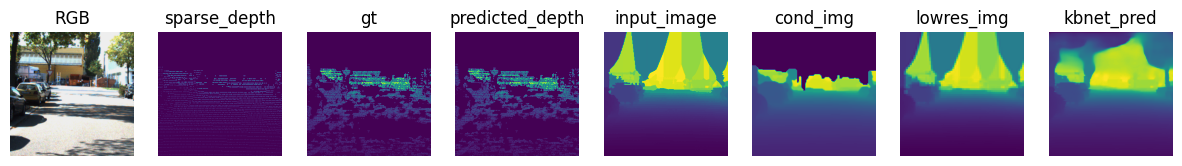

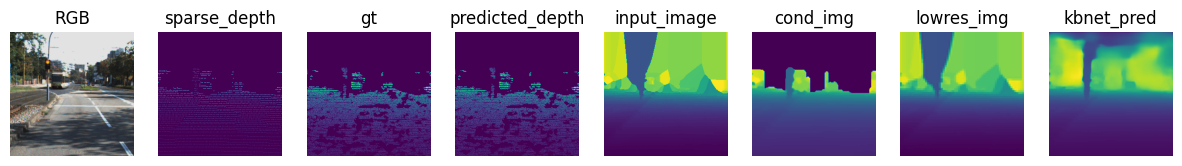

Evaluation results (trainer)
     MAE      RMSE      iMAE     iRMSE
   0.000     0.000     0.000     0.000
     +/-       +/-       +/-       +/-
   0.000     0.000     0.000     0.000
Evaluation results (kbnet)
     MAE      RMSE      iMAE     iRMSE
 455.709  1352.921     0.838     1.387
     +/-       +/-       +/-       +/-
 211.562   568.195     0.253     0.383


In [28]:
from rsl_depth_completion.conditional_diffusion.kbnet_utils import load_kbnet
from rsl_depth_completion.conditional_diffusion.utils import plot_full_prediction

# eval_batch["rgb"] = (eval_batch["rgb"]) / 255
# eval_batch["sdm"] = (eval_batch["sdm"]) * 80
kbnet_predictor = load_kbnet()
figs=plot_full_prediction(
    eval_batch=eval_batch,
    output_depths=eval_batch['gt'],
    kbnet_predictor=kbnet_predictor,
    # idx_to_use=-1,
)

In [29]:
eval_batch['sdm'].shape

torch.Size([2, 1, 256, 256])

In [23]:
from rsl_depth_completion.conditional_diffusion.data_utils import (
    update_eval_batch_file,
    fill_eval_batch_with_coco,
)
# eval_batch = torch.utils.data.default_collate([ds[sample0_idx], ds[sample1_idx]])
# plot_batch(eval_batch)

do_resave_eval_batch = True
update_eval_batch_file(
    eval_batch,
    cfg,
    image_paths=[ds.ds.image_paths[sample0_idx], ds.ds.image_paths[sample1_idx]],
    do_resave_eval_batch=do_resave_eval_batch,
    filename="eval_batch.pt",
)

saved for 256


In [11]:
eval_batch_std = torch.load("eval_batch.pt")[64]
lowres_img = eval_batch_std['input_img'][0]
plt.imshow(lowres_img.permute(1,2,0)/lowres_img.max())

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:1                                                                                    │
│                                                                                                  │
│ ❱ 1 eval_batch_std = torch.load("eval_batch_ssl.pt")[64]                                         │
│   2 lowres_img = eval_batch_std['input_img'][0]                                                  │
│   3 plt.imshow(lowres_img.permute(1,2,0)/lowres_img.max())                                       │
│   4                                                                                              │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
KeyError: 64

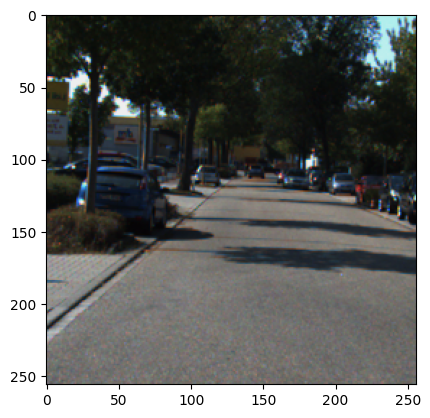

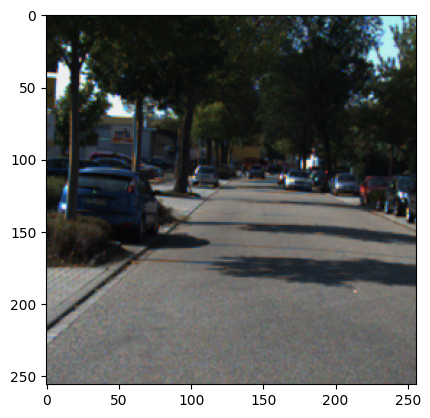

In [54]:
batch_size=2
input_res = cfg.input_res
eval_batch_ssl = {k:v[:batch_size] for k,v in torch.load("eval_batch_ssl.pt")[input_res].items()}
for img in eval_batch_ssl["adj_imgs"][0]:
    plt.imshow(img.permute(1, 2, 0).numpy()/255)
    plt.show()